epoch:  0 
   aperark
[erirere, loo the,
To mabe con houf wers prorserongragr,
Alithietime;
aCate:
Ald her spame 
loss:  23.1538319087
epoch:  10 
  gEnks rivitho pond; hit may, felwent
Thad highall nevelon hand his the, stoolied but them bescee sho
loss:  19.3855476163
epoch:  20 
  T NU*****
That by to hemell, now,
Mish thit art you so sulvengting lagd
My show'll reItthious coustl
loss:  18.9270036712
epoch:  30 
   Eous bocrestrarf.

Canasiunt.

Ham.
Guching in the ofer's they ale seper grach. Not is us cocliaver
loss:  18.6983773826
epoch:  40 
  -

Of lam you earses witl of waroly timnlasions, bade, and should hasce wheren pricotherove eter gro
loss:  18.5535858448
epoch:  49 
   cpancel Hyg.
I do swertufuef.

My, my lord?
Iostal braught shoudtligh, frow.
I could ewpenste; frum
loss:  18.4595855458


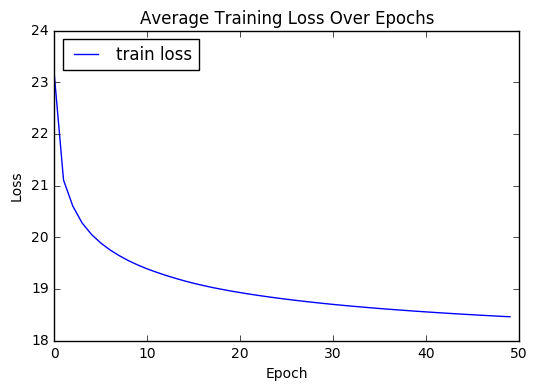

In [1]:
import numpy as np 
import random
import string
import matplotlib.pyplot as plt


vocab_size = 256
epochs = 50
alpha = .1
hidden_size = 50 
seq_size = 10 
corpus = open('data/hamlet.txt', 'r').read()

def randInit():
    Wxh = np.random.normal(0, 1/np.sqrt(vocab_size), [hidden_size, vocab_size])
    Whh = np.random.normal(0, 1/np.sqrt(hidden_size), [hidden_size, hidden_size])
    Why = np.random.normal(0, 1/np.sqrt(hidden_size), [vocab_size, hidden_size])
    bh = np.random.normal(0, 1/np.sqrt(hidden_size), [hidden_size, 1])
    by = np.random.normal(0, 1/np.sqrt(hidden_size), [vocab_size, 1])
    return Wxh, Whh, Why, bh, by

# compute gradients for weight updates
def computeGradients(trainInputs, targets, lastHidState, temperature=1):
    
    train_loss = 0
    x, h, y, p = {}, {}, {}, {}
    h[-1] = np.copy(lastHidState)
    acc = 0
    # forward prop
    for t in range(len(trainInputs)):
        x[t] = np.zeros((vocab_size,1)) 
        x[t][trainInputs[t]] = 1
        h[t] = np.tanh(np.dot(Wxh, x[t]) + np.dot(Whh, h[t-1]) + bh) 
        y[t] = np.dot(Why, h[t]) + by 
        p[t] = np.exp(y[t]) / np.sum(np.exp(y[t])) # probabilities for next char       

        train_loss += -np.log(p[t][targets[t],0]) # compute CE loss
        
        # for training accuracy
        if targets[t] == np.where(p[t] == np.max(p[t]))[0]:
            acc += 1

    # backprop
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(h[0])
    for t in reversed(range(len(trainInputs))):
        dy = np.copy(p[t])
        dy[targets[t]] -= 1 
        dWhy += np.dot(dy, h[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext 
        dhraw = (1 - h[t]**2) * dh 
        dbh += dhraw
        dWxh += np.dot(dhraw, x[t].T)
        dWhh += np.dot(dhraw, h[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)

    return dWxh, dWhh, dWhy, dbh, dby, h[len(trainInputs)-1], train_loss

# output a sequence using trained network
def generateSequence(h, temp=1):
    
    startChar = ord(random.choice(string.ascii_lowercase).upper())
    x = np.zeros((vocab_size, 1))
    x[startChar] = 1
    sequence = []
    for t in range(0,100):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = (np.exp(y/temp)) / (np.sum(np.exp(y/temp)))
        
        #make sure generated character is actually from our training text
        nextChar = len({ l:char for l,char in enumerate(list(set(corpus))) }.keys()) + 1
        while len({ l:char for l,char in enumerate(list(set(corpus))) }.keys()) < nextChar:
            nextChar = np.random.choice(range(vocab_size), p=p.ravel())
        
        x = np.zeros((vocab_size, 1))
        x[nextChar] = 1
        sequence.append(nextChar)

    return sequence

# initialize variables for Adagrad
adaWxh, adaWhh, adaWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
adabh, adaby = np.zeros_like(bh), np.zeros_like(by) 
trainLoss = []
randInit()

for e in range(0,epochs):
    lastHidState = np.zeros((hidden_size,1)) 
    hprevprev = np.zeros((hidden_size,1)) 
    training_loss = 0

    for ptr in range(0, len(corpus)-seq_size, seq_size):
        
        inp = [{ ch:i for i,ch in enumerate(list(set(corpus))) }[ch] for ch in corpus[ptr:ptr+seq_size]]
        targ = [{ ch:i for i,ch in enumerate(list(set(corpus))) }[ch] for ch in corpus[ptr+1:ptr+seq_size+1]]            

        #forward/backprop to compute gradients
        dWxh, dWhh, dWhy, dbh, dby, lastHidState, loss = computeGradients(inp, targ, lastHidState)
        training_loss += loss
        # perform weight/bias updates with adagrad
        adaWxh += dWxh * dWxh
        adaWhh += dWhh * dWhh
        adaWhy += dWhy * dWhy
        adabh += dbh * dbh
        adaby += dby * dby
        
        Wxh -= (alpha * dWxh) / np.sqrt(adaWxh + 1e-8)
        Whh -= (alpha * dWhh) / np.sqrt(adaWhh + 1e-8)
        Why -= (alpha * dWhy) / np.sqrt(adaWhy + 1e-8)
        by -= (alpha * dby) / np.sqrt(adaby + 1e-8)
        bh -= (alpha * dbh) / np.sqrt(adabh + 1e-8)
        
    # average training loss over number of windows
    trainLoss.append(training_loss/(len(corpus)/seq_size))
    
    if e%10 == 0 or e==(epochs-1):
        # generate new sequence, convert from list to string
        newSequence = generateSequence(lastHidState)
        newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
        print('epoch: ', e, '\n ', newSeq)
        print('loss: ', trainLoss[-1])
    
#temperature code
'''
print('5 outputs no temp:\n')
newSequence = generateSequence(lastHidState)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output1: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output2: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output3: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output4: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output5: \n', newSeq, '\n')

# generate new sequences with temperature
print('temperature 0.05:\n')
newSequence = generateSequence(lastHidState, 0.05)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output1: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState, 0.05)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output2: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState, 0.05)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output3: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState, 0.05)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output4: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState, 0.05)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output5: \n', newSeq, '\n')

print('-----')
print('temperature 2:\n')
newSequence = generateSequence(lastHidState, temp=2)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output1: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState, temp=2)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output2: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState, temp=2)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output3: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState, temp=2)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output4: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState, temp=2)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output5: \n', newSeq, '\n')

print('-----')
print('temperature 3:\n')
newSequence = generateSequence(lastHidState, 3)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output1: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState, 3)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output2: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState, 3)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output3: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState, 3)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output4: \n', newSeq, '\n')
newSequence = generateSequence(lastHidState, 3)
newSeq = ''.join({ l:char for l,char in enumerate(list(set(corpus))) }[num] for num in newSequence)
print('output5: \n', newSeq, '\n')
'''

plt.plot(trainLoss)
plt.title('Average Training Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss'], loc='upper left')
plt.show()
